# Google Colab Setup

In [1]:
#@title << Setup Google Colab by running this cell {display-mode: "form"}
import sys
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/pxydi/amld20_text_classification.git
        
    # Copy files required to run the code
    !cp -r "amld20_text_classification/data" "amld20_text_classification/tools.py" .
    
    # Install packages via pip
    !pip install -r "amld20_text_classification/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

# Text classification : Spam detection

## Task 

We want to build a Spam detector which, given examples of spam emails (e.g. flagged by users) and examples of regular (non-spam, also called "ham") emails, learns how to flag new unseen emails as spam or non-spam.

## Data

We will use the [SpamAssassin](https://spamassassin.apache.org/) public email corpus. This dataset contains ~6'000 labeled emails with a ~30% spam ratio. If you want to learn more about this dataset, check [this](https://spamassassin.apache.org/old/publiccorpus/). (*Note: Datasets of text are called corpora and samples are called documents.*) 

The dataset has been downloaded for you and is available in the *data* folder.

## Notebook overview

* Load the data
* Text preprocessing
* Data exploration
* Feature extraction
* Build a spam detector
* What did our model learn? Error analysis

## 1. The data

In [2]:
# Load libraries and helper functions

import tools

In [3]:
# Load the data

df = tools.load_data()

Data loaded.
Data size: (5832, 2)


Let's have a look at a few rows from the dataset.

***Note:*** *label* is 0 for *non-spam* and 1 for *spam*.

In [4]:
df.sample(3)

,label,text
588,0,"<html><head><!-- CLICK HERE to read this newsletter on the Web for FREE: <a href=""http://www.lockergnome.com/issues/digitalmedia/20020722.html""> http://www.lockergnome.com/issues/digitalmedia/20020722.html </a> To unsubscribe, please e-mail the following address: leave-lgmedia-2534370N@sprocket.lockergnome.com To resubscribe, visit our site: http://www.lockergnome.com Don't worry about anything else below this paragraph. It's for those with HTML e-mail clients. Just go to the above listed web address to view this issue perfectly in your web browser. Thanks again! --> <style type=""text/css""> <!-- body { BACKGROUND-IMAGE: url(http://images.lockergnome.com/images/issue/top-right.gif); scrollbar-3dlight-color: #DEE8EC; scrollbar-arrow-color: #000000; scrollbar-base-color: #007C7A; scrollbar-darkshadow-color: #507686; scrollbar-face-color: #A9C4CF; scrollbar-highlight-color: #DEE8EC; scrollbar-shadow-color: #507686 } a:link { COLOR: #0000FF; TEXT-DECORATION: underline; font-weight: normal } a:visited { COLOR: #000000; TEXT-DECORATION: underline; font-weight: normal } a:active { color: #000000; TEXT-DECORATION: none } a:hover { color: #26343A; TEXT-DECORATION: none } p.title { BACKGROUND: #A9C4CF; BORDER-BOTTOM: #507686 4px solid; BORDER-LEFT: #DEE8EC 4px solid; BORDER-RIGHT: #507686 4px solid; BORDER-TOP: #DEE8EC 4px solid; COLOR: #26343A; FONT-FAMILY: Comic Sans MS, Trebuchet MS, Helvetica, Arial; FONT-SIZE: 14pt; FONT-WEIGHT: normal } p.news { BACKGROUND: #A9C4CF; BORDER-BOTTOM: #507686 4px solid; BORDER-LEFT: #DEE8EC 4px solid; BORDER-RIGHT: #507686 4px solid; BORDER-TOP: #DEE8EC 4px solid; COLOR: #26343A; FONT-FAMILY: Comic Sans MS, Trebuchet MS, Helvetica, Arial; FONT-SIZE: 18pt; FONT-WEIGHT: normal } p.sidebar { BACKGROUND: #A9C4CF; BORDER-BOTTOM: #507686 3px solid; BORDER-LEFT: #DEE8EC 3px solid; BORDER-RIGHT: #507686 3px solid; BORDER-TOP: #DEE8EC 3px solid; COLOR: #26343A; FONT-FAMILY: Comic Sans MS, Trebuchet MS, Helvetica, Arial; FONT-SIZE: 10pt; FONT-WEIG..."
3484,0,"cwg-dated-1030817858.a49b7e@DeepEddy.Com said: > From: Anders Eriksson <aeriksson@fastmail.fm> > Date: Mon, 26 Aug 2002 20:00:36 +0200 > > > lately I've got the feeling that exmh is getting slower and slower. I > just decided to check that vs. reality, and yes, speed has left the > scene somewhere between the release of 2.5 and now. > > I checked on a number of small messages in a big folder (~10000 > msgs). The delay of the Next button has increased considerably: > > 2.5-release: 350-450 msec > latest cvs: 1000-12000 msec > > Frankly I think this is getting close to non-acceptable since the > user settings hasn't changed. > > Anybody have any ideas where performance disappeared? > Most likely in the added overhead of managing more sequences. > I'm sure it can be tuned a bunch, but as I'm leaving for a vacation on > Friday, and have plenty of ""real work"" to do, I won't be able to do > much until I get back. > I *will* look at all this when I get back, but if you want to check > into what's slow and fix things while I'm gone, my feelings won't be > hurt. > Chris Just one more info. I measured the time spent wrapping the stuff in Ftoc_Next with time {} so the data is for real. One difference between mine and Valdis' setup (judging from his trace) is that I use the address book. I've been doing that for ages so that can't be the problem. Is there a way to get the log to print time with higher granularity? /A _______________________________________________ Exmh-workers mailing list Exmh-workers@redhat.com https://listman.redhat.com/mailman/listinfo/exmh-workers"
3628,0,"URL: http://www.newsisfree.com/click/-2,8418828,215/ Date: 2002-10-01T04:33:56+01:00 *Media:* The race is on for the most coveted job in BBC News after Rod Liddle says he is stepping down as editor of the Today programme."


Now, let's check the number of samples per class in the data.

Samples per class (%):
non-spam    70.3
spam        29.7
Name: label, dtype: float64




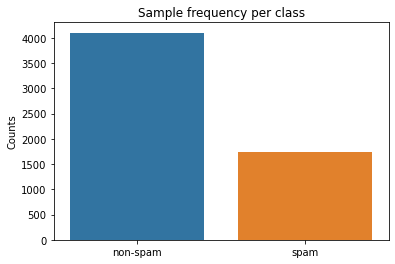

In [5]:
tools.plot_class_frequency(df)

## 2. Text preprocessing

Good text preprocessing is an essential part of every NLP project!

Our goal here is to build a model that distinguishes non-spam from spam. The idea here is to "clean" and "standardize" raw text before feeding it to our machine learning model. We need to keep as many "informative" words as possible, while discarding the "uniformative" ones. Removing unnecessary content, i.e. the "noise", from our texts will help to improve the accuracy of our models.

**Take a few minutes to look at the raw text. What do you think should be removed from the text?**

Below are a few pointers:

* HTML tags 
* URLs
* E-mail addresses
* Punctuation marks, digits (e.g. 2002, 1.1, ...)
* Multiple whitespace
* Case conversion (e.g. Dog vs dog, ...)
* English STOPWORDS (e.g. a, is, my, i, all, and, by...)
* ...

The *clean_corpus* function below takes care of all of that!

In [6]:
df = tools.clean_corpus(df)

print('Data cleaned')

Data cleaned


Let's have a look at a few "cleaned" examples.

In [7]:
tools.show_clean_text(df)


Original document:

I am new to linux. Is that an easy way to identify which rpm / rpms to which hardware devices or
software packages? Regards, Yen Ho (Technical Support)
_______________________________________________ RPM-List mailing list <RPM-List@freshrpms.net>
http://lists.freshrpms.net/mailman/listinfo/rpm-list

Cleaned document:

linux easy identify rpms hardware devices software packages regards technical support list mailing
list


## 3. Data Exploration : What makes spam distinct?

### 2.1 Frequent words

Which words distinguish spam from non-spam? Can we  identify the words in a text that are the most informative about its topic?

Let's find the most frequent words in spam and non-spam.

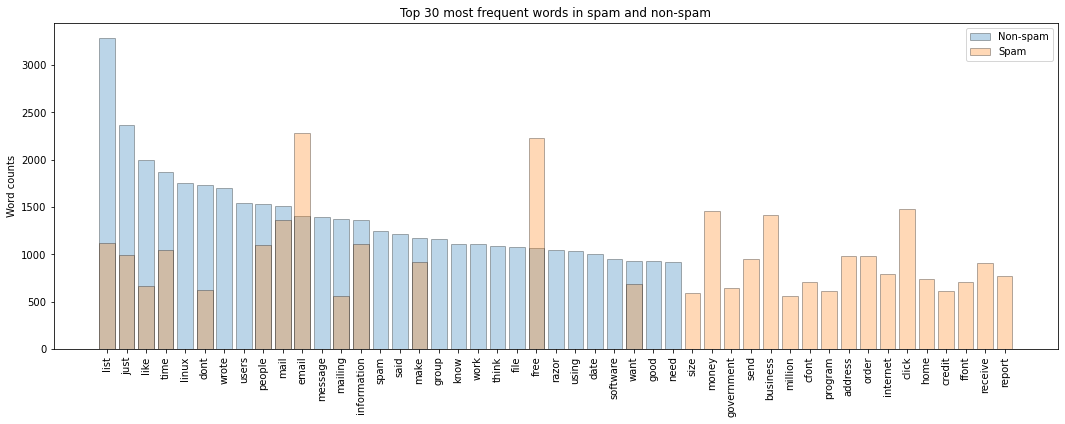

In [8]:
tools.plot_most_common_words(df=df, N=30)

**Frequent "spammish" words**: 

* click
* money
* business
* free
* email
* ...

**Frequent "non-spammish" words**:
* list
* linux
* message
* wrote
* users
* spam
* said
* file
* good
* ...

### 2.2 What about "spammish" signatures?

* Do spams contain more HTML tags? 
* Does non-spam contain more URLs and E-mail adresses? 
* Are spams mails longer than non-spam? 
* ...

Let's find out!

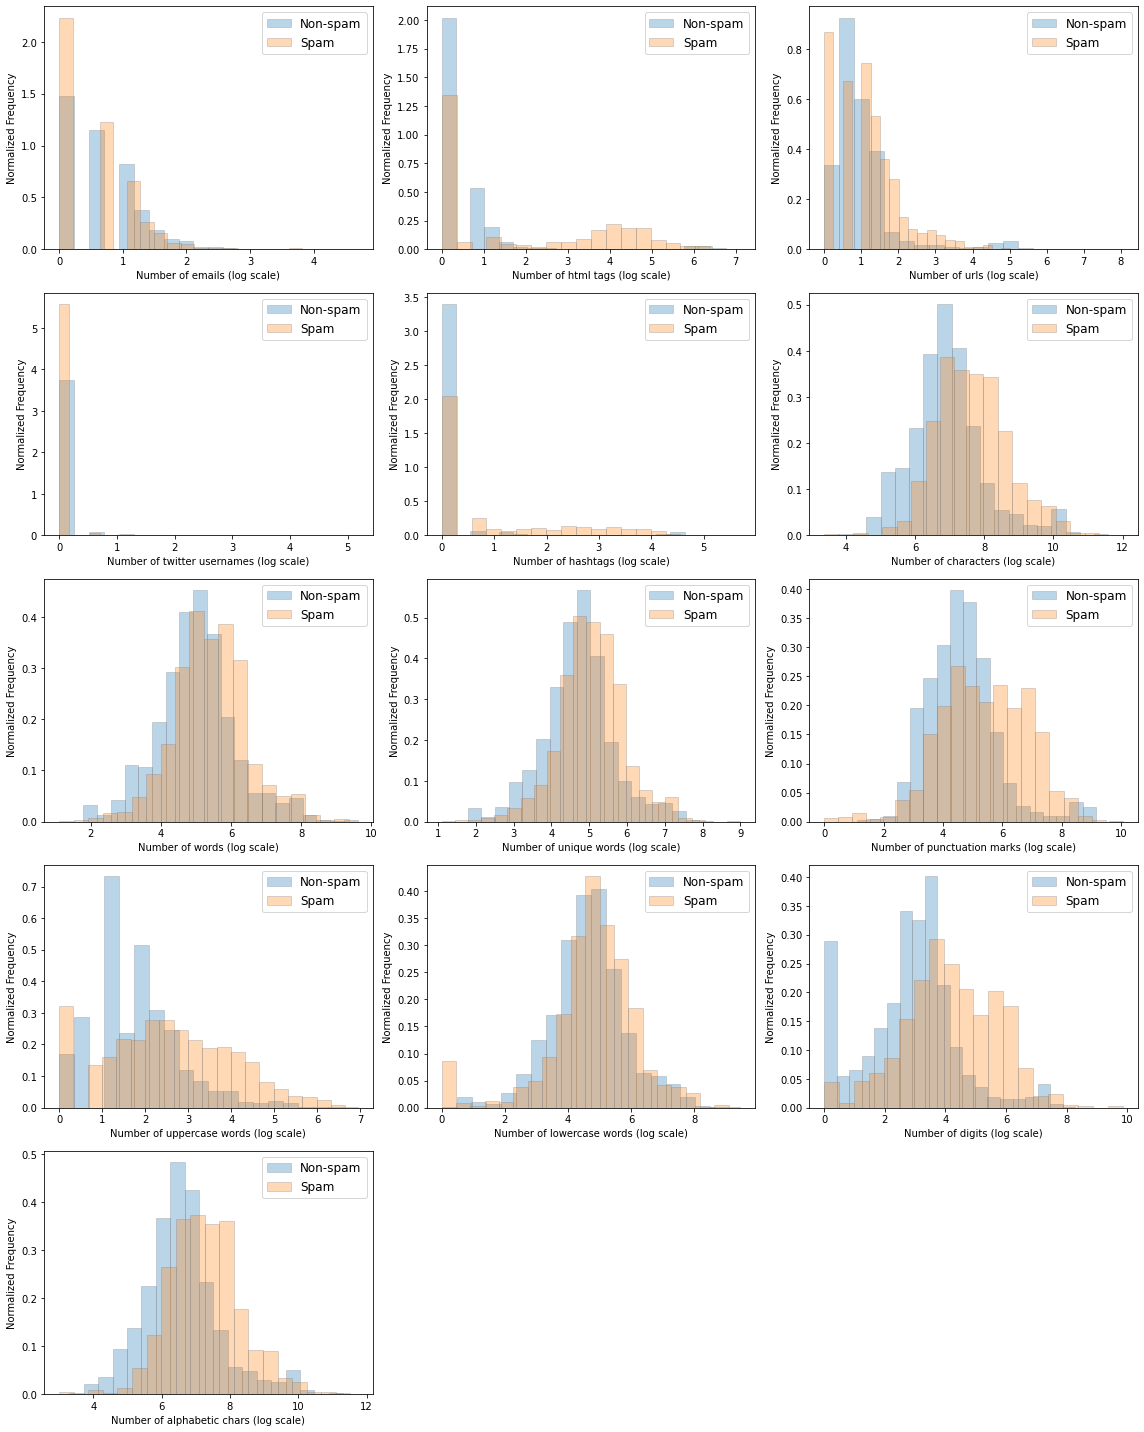

In [9]:
features = tools.get_features(df=df)

## 3. Feature engineering : Extracting features from text

Computers don't understand natural language. So, how do we represent text?

One of the simplest but effective and commonly used models to represent text for machine learning is the ***Bag of Words*** model ([online documentation](https://en.wikipedia.org/wiki/Bag-of-words_model)). When using this model, we discard most of the structure of the input text (word order, chapters, paragraphs, sentences and formating) and only count how often each word appears in each text. Discarding the structure and counting only word occurencies leads to the mental image of representing text as a "bag".  

**Example:** Let our toy corpus contain four documents.

$ corpus = ['I\;enjoy\;paragliding.',  $  
$\hspace{2cm}'I\;like\;NLP.',$  
$\hspace{2cm}'I\;like\;deep\;learning.',$  
$\hspace{2cm}'O\;Captain!\;my\;Captain!']$ 

In [10]:
tools.show_bag_of_words_vector()

,captain,deep,enjoy,i,learning,like,my,nlp,o,paragliding
Text,,,,,,,,,,
I enjoy paragliding.,0,0,1,1,0,0,0,0,0,1
I like NLP.,0,0,0,1,0,1,0,1,0,0
I like deep learning.,0,1,0,1,1,1,0,0,0,0
O Captain! my Captain!,2,0,0,0,0,0,1,0,1,0


Bag of Words has converted all documents into numeric vectors. Each column represents a word from the corpus and each row one of the four documents. The value in each cell represents the number of times that word appears in a specific document. For example, the fourth document has the word `captain` occuring twice and the words `my` and `O` occuring once.

## 4. Build a spam detector

In the previous section, we saw how to perform text preprocessing and feature extraction from text. We are now ready to build our machine learning model for detecting spams. We will use a Logistic Regression classifier ([online documentation](https://en.wikipedia.org/wiki/Logistic_regression)).

First, we need to split the data into two sets: the `train` set and the `test` set. We will then use the train set to `fit` our model. The test set will be used to `evaluate` the performance of our model. 

### 4.1 Spam classification

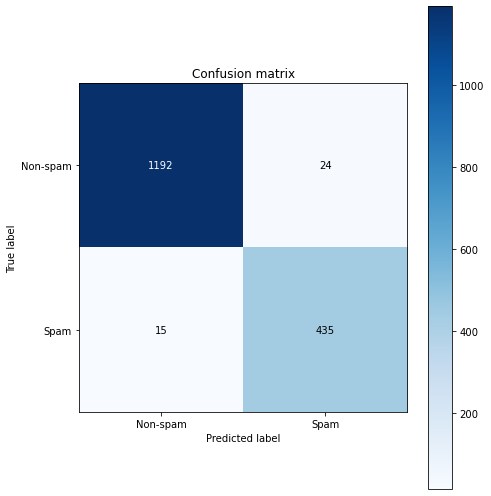

In [11]:
# Train/test splitting
df_train, df_test = tools.train_test_split_(df)

# Fit model on the train data
model = tools.fit_model(df_train)

# Print predictions on test set
tools.plot_confusion_matrix(df_test,model);

**Confusion matrices**  

Confusion matrices are a nice way of evaluating the performance of models for classification models. Rows correspond to the true classes and the columns to the predicted classes. Entries on the main diagonal of the confusion matrix correspond to correct predictions while the other cells tell us how many mistakes made our model ([online documentation]((https://en.wikipedia.org/wiki/Confusion_matrix))).

* The first row represents non-spam mails: 1'187 were correctly classified as 'non-spam', while 29 (~2,3%) were misclassified as 'spam'.
* The second row represents spam mails: 437 were correctly classified as 'spam', while 13 (~2,8%) were misclassified as 'non-spam'.

Our model did quite well!

### 4.2 What did our model learn from the data?

Our logistic regression model has learned which words are the most indicative of non-spam and which words are the most indicative of spam. The positive coefficients on the right correspond to words that, according to the model, are indicative of spam. The negative coefficients on the left correspond to words that, according to the model, are indicative of non-spam.

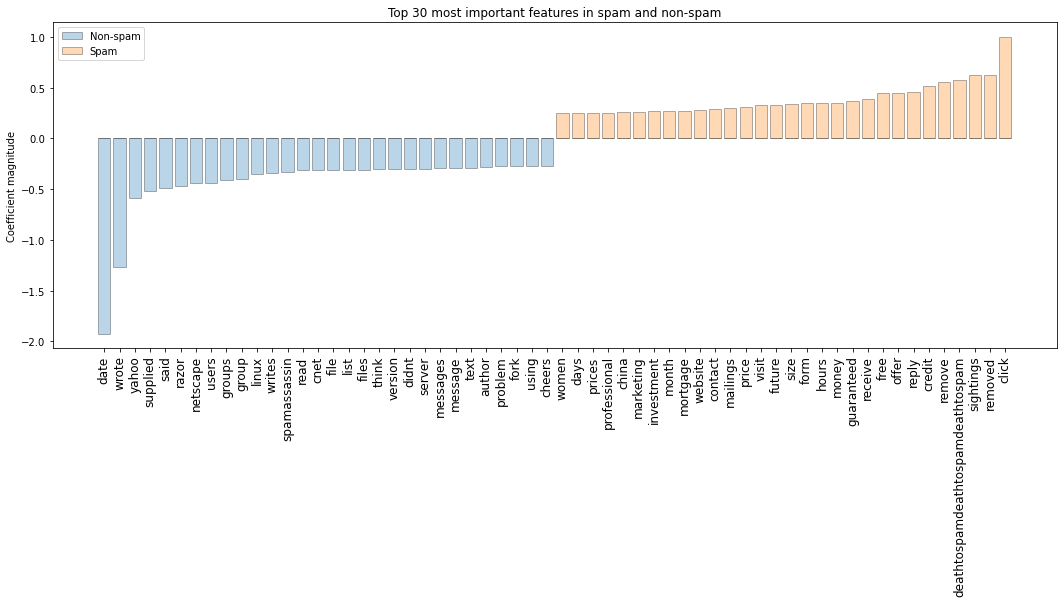

In [12]:
tools.visualize_coefficients(model, n_top_features=30)

According to the model, words such as "date", "wrote", "yahoo", "said", "linux", "author", ... are strong indicators of non-spam.  

Words such as "click", "credit", "remove", "free", "offer", "money" ... indicate spam. 

### 4.3 Error analysis :: Where does our model fail?

We will now analyze the misclassified mails in order to get some insights on where the model failed to make correct predictions. The *error_analysis* function below will show us the top features responsible for the model making a decision of prediction whether the mail is spam or non-spam.

Document index: 16 


Original Text
<html><body> <center> <font face="arial"><b>Talk on Tele with locals in your area who want to meet
for real encounters. No pre recorded bull this is the real deal. <p> US residents: the 9<!--dads
tools-->00-370-54<!--starter-->65 or 8<!--ender-->88-400-1<!--end-->919. - 99<!--hi hi --> cents /
min <p> For CA callers try our special California line, California is so popular we had to create a
seperate system just for them <p> : 1-<!--moms-->9<!--low-->00-505-7575. <p> must be 18<!--none-->+
be careful when making sexual dates and meetings. Cali 9<!--polic cars-->00# is $1.99 per min
</html> 211075433222 


Cleaned text
talk tele locals area want meet real encounters recorded bull real deal residents cents callers
special california line california popular create seperate just careful making sexual dates meetings
cali 


Actual class:     Spam
Predicted class:  Non-spam 


Predicted probabilities

Non-spam:   0.5239
Spam:       0.4761



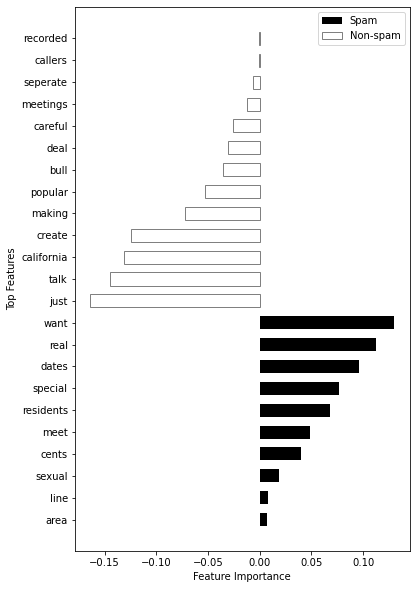

In [13]:
tools.error_analysis(df_test,model,doc_nbr=16)